Preprocessing

In [2]:
!pip install num2words
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from num2words import num2words

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Convert numbers to their word equivalents
    words = [num2words(i) if i.isdigit() else i for i in words]
    # Remove stopwords and apply lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tag(words) if word not in stop_words]
    return words

def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data['processed_text'] = data['medical_abstract'].apply(preprocess_text)
    return data

data = load_and_preprocess_data('/content/drive/MyDrive/data.csv')

# TF-IDF Transformation
vectorizer = TfidfVectorizer(analyzer=lambda x: x, ngram_range=(2, 5))
tfidf_matrix = vectorizer.fit_transform(data['processed_text'])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=a4c6cfe9bb3f53dc4d641486507d2c3d4b316daf3b5995704d5e8377872dd693
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Splitting the Data

In [9]:
from sklearn.model_selection import train_test_split

train_val, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val, test_size=0.25, random_state=42)

Feature Engineering for Traditional Models:
SVMs, logistic regression, etc.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = vectorizer.transform(test_data['processed_text']).toarray()

y_train = train_data['condition_label']
y_val = val_data['condition_label']
y_test = test_data['condition_label']

 Preparing for BERT and Other Transformers

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_for_bert(data):
    texts = data['processed_text'].tolist()
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_for_bert(train_data)
val_encodings = tokenize_for_bert(val_data)
test_encodings = tokenize_for_bert(test_data)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


*Model Training:*

In [ ]:
#SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the model and parameter grid
svc = SVC()
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Setup GridSearchCV
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')

# Fit the model
grid_search_svc.fit(X_train_tfidf, y_train)

# Evaluate the model
best_svc = grid_search_svc.best_estimator_
print(f"Best Parameters for SVM: {grid_search_svc.best_params_}")


### Decision Tree


Training a Decision Tree model using the default hyperparameters and evaluate its.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree model with default hyperparameters
dt_classifier = DecisionTreeClassifier()

# Train the Decision Tree model
dt_classifier.fit(X_train_tfidf, y_train)

# Predict on the test data
y_test_pred = dt_classifier.predict(X_test_tfidf)
# Predict on the validation data
y_val_pred = dt_classifier.predict(X_val_tfidf)

# Evaluate the model on the test data for accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy on Test Data:", test_accuracy)

# Evaluate the model on the validation data for accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy on Validation Data:", val_accuracy)


Accuracy on Test Data: 0.4268349696119682
Accuracy on Validation Data: 0.44340505144995324


#### Hyperparameter tuning

Useing the GridSearchCV module of the sklearn library to tune the hyperparameter of the Decision Tree model on the validation set.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree model
dt_classifier = DecisionTreeClassifier()

# Set up the parameter grid to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

# Best estimator
best_dt = grid_search.best_estimator_

# Predict on the validation data using the best found parameters
y_val_pred = best_dt.predict(X_val_tfidf)

# Evaluate the model on the validation data for accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Best Parameters:", grid_search.best_params_)
print("Accuracy on Validation Data with Best Parameters:", val_accuracy)


Fitting 5 folds for each of 2736 candidates, totalling 13680 fits


KeyboardInterrupt: 

In [4]:
# Check for class imbalance
class_counts = train_data['condition_label'].value_counts()
print(class_counts)

condition_label
5    2279
1    1525
4    1436
3     949
2     741
Name: count, dtype: int64


**Neural Networks**


Epoch 1/10
217/217 [==============================] - 57s 252ms/step - loss: 1.0613 - accuracy: 0.5351 - precision: 0.6408 - recall: 0.3329 - auc: 0.8249 - val_loss: 0.9599 - val_accuracy: 0.6074 - val_precision: 0.6944 - val_recall: 0.4299 - val_auc: 0.8827
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 46s 214ms/step - loss: 0.8031 - accuracy: 0.6355 - precision: 0.6873 - recall: 0.5323 - auc: 0.9010 - val_loss: 0.9360 - val_accuracy: 0.5983 - val_precision: 0.6457 - val_recall: 0.5113 - val_auc: 0.8862
Epoch 3/10
217/217 [==============================] - 53s 245ms/step - loss: 0.6641 - accuracy: 0.6974 - precision: 0.7336 - recall: 0.6398 - auc: 0.9304 - val_loss: 0.9858 - val_accuracy: 0.5944 - val_precision: 0.6180 - val_recall: 0.5147 - val_auc: 0.8783
Epoch 4/10
217/217 [==============================] - 51s 237ms/step - loss: 0.5657 - accuracy: 0.7455 - precision: 0.7712 - recall: 0.7043 - auc: 0.9488 - val_loss: 1.0712 - val_accuracy: 0.5537 - val_precision: 0.5688 - val_recall: 0.5082 - val_auc: 0.8656
Epoch 5/10
217/217 [==============================] - 48s 222ms/step - loss: 0.4745 - accuracy: 0.7941 - precision: 0.8078 - recall: 0.7677 - auc: 0.9632 - val_loss: 1.1681 - val_accuracy: 0.5667 - val_precision: 0.5842 - val_recall: 

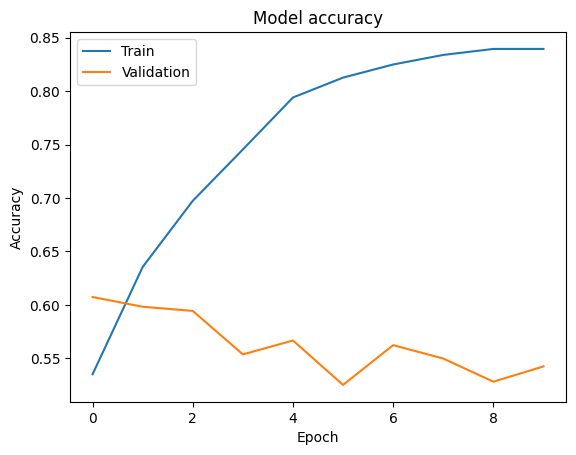

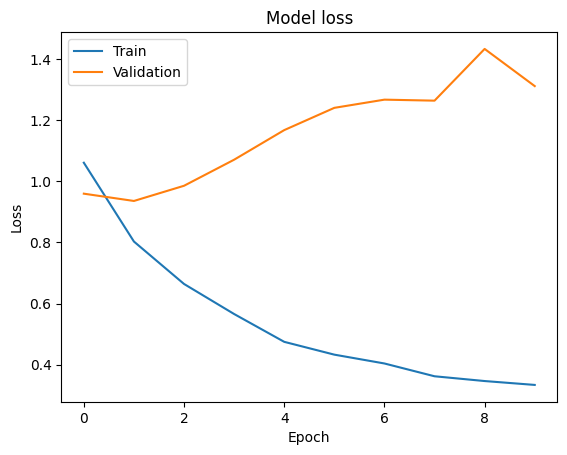

73/73 [==============================] - 8s 102ms/step
              precision    recall  f1-score   support

           1       0.65      0.77      0.71       526
           2       0.45      0.49      0.47       230
           3       0.44      0.49      0.47       296
           4       0.59      0.76      0.66       485
           5       0.46      0.29      0.35       773

    accuracy                           0.54      2310
   macro avg       0.52      0.56      0.53      2310
weighted avg       0.53      0.54      0.52      2310



In [5]:
#version 2
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import gensim

# Load Word2Vec model (make sure you've downloaded it first)
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['processed_text'])
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
val_sequences = tokenizer.texts_to_sequences(val_data['processed_text'])

# Pad sequences
max_length = max([len(s) for s in train_data['processed_text']])
train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_sequences = pad_sequences(val_sequences, maxlen=max_length, padding='post')

# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in word2vec.key_to_index:  # Use .key_to_index instead of .vocab
        embedding_matrix[i] = word2vec.get_vector(word)  # Use .get_vector(word) instead of .word_vec(word)


# Create a copy of the labels and subtract 1 to make them 0-indexed
train_labels = train_data['condition_label'].copy() - 1
val_labels = val_data['condition_label'].copy() - 1

# Convert labels to one-hot vectors
num_classes = 5  # Set this to the actual number of classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

from keras import metrics

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall'),
                       metrics.AUC(name='auc')])



# Calculate class weights
class_weights = class_weight.compute_sample_weight('balanced', train_data['condition_label'])

# Convert class weights to dictionary
class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=10, callbacks=[checkpoint], class_weight=class_weight_dict)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Get predictions
preds = model.predict(val_sequences)
preds = np.argmax(preds, axis=1)  # Convert probabilities to class labels

# Add 1 to get the original labels
preds = preds + 1

# Calculate metrics
report = classification_report(np.argmax(val_labels, axis=1) + 1, preds)
print(report)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00
Epoch 1/10
217/217 [==============================] - ETA: 0s - loss: 1.5382 - accuracy: 0.2680 - precision: 0.2739 - recall: 0.0124 - auc: 0.6004

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 55s 239ms/step - loss: 1.5382 - accuracy: 0.2680 - precision: 0.2739 - recall: 0.0124 - auc: 0.6004 - val_loss: 1.4883 - val_accuracy: 0.4100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7018
Epoch 2/10
217/217 [==============================] - 55s 255ms/step - loss: 1.3449 - accuracy: 0.3880 - precision: 0.5782 - recall: 0.0736 - auc: 0.7044 - val_loss: 1.2235 - val_accuracy: 0.5502 - val_precision: 0.6810 - val_recall: 0.3290 - val_auc: 0.8084
Epoch 3/10
217/217 [==============================] - 49s 225ms/step - loss: 1.1717 - accuracy: 0.4909 - precision: 0.6166 - recall: 0.2309 - auc: 0.7795 - val_loss: 1.1399 - val_accuracy: 0.5636 - val_precision: 0.6707 - val_recall: 0.3580 - val_auc: 0.8304
Epoch 4/10
217/217 [==============================] - 53s 245ms/step - loss: 1.0975 - accuracy: 0.5260 - precision: 0.6390 - recall: 0.2902 - auc: 0.8080 - val_loss: 1.0999 - val_accuracy: 0.5727 - val_precision: 0.6856 - val_

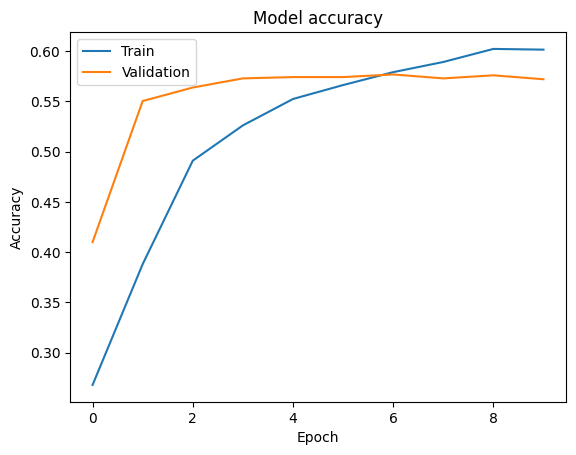

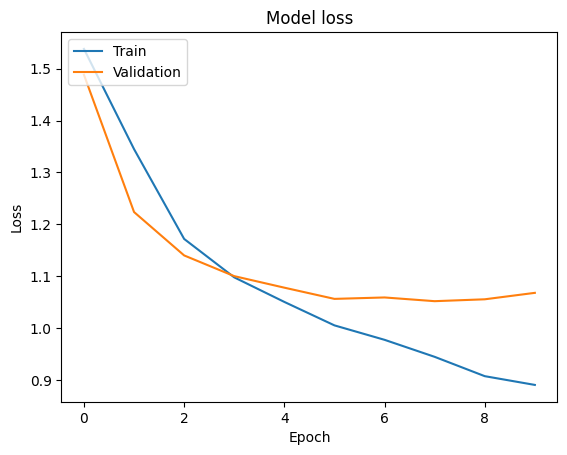

73/73 [==============================] - 7s 92ms/step
              precision    recall  f1-score   support

           1       0.73      0.81      0.77       526
           2       0.00      0.00      0.00       230
           3       0.00      0.00      0.00       296
           4       0.63      0.84      0.72       485
           5       0.45      0.63      0.53       773

    accuracy                           0.57      2310
   macro avg       0.36      0.46      0.40      2310
weighted avg       0.45      0.57      0.50      2310



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
#with dropout layers
#version 2
!pip install keras-preprocessing

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import gensim

# Load Word2Vec model (make sure you've downloaded it first)
word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['processed_text'])
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
val_sequences = tokenizer.texts_to_sequences(val_data['processed_text'])

# Pad sequences
max_length = max([len(s) for s in train_data['processed_text']])
train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_sequences = pad_sequences(val_sequences, maxlen=max_length, padding='post')

# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in word2vec.key_to_index:  # Use .key_to_index instead of .vocab
        embedding_matrix[i] = word2vec.get_vector(word)  # Use .get_vector(word) instead of .word_vec(word)


# Create a copy of the labels and subtract 1 to make them 0-indexed
train_labels = train_data['condition_label'].copy() - 1
val_labels = val_data['condition_label'].copy() - 1

# Convert labels to one-hot vectors
num_classes = 5  # Set this to the actual number of classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)

from keras.layers import Conv1D, GlobalMaxPooling1D

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='sigmoid'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

from keras import metrics

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall'),
                       metrics.AUC(name='auc')])



# Calculate class weights
class_weights = class_weight.compute_sample_weight('balanced', train_data['condition_label'])

# Convert class weights to dictionary
class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=10, callbacks=[checkpoint], class_weight=class_weight_dict)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Get predictions
preds = model.predict(val_sequences)
preds = np.argmax(preds, axis=1)  # Convert probabilities to class labels

# Add 1 to get the original labels
preds = preds + 1

# Calculate metrics
report = classification_report(np.argmax(val_labels, axis=1) + 1, preds)
print(report)


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Define the hyperparameters
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
neurons = [16, 32, 64, 128, 256]

# Create a list of all possible combinations of hyperparameters
param_combinations = list(itertools.product(optimizers, dropouts, neurons))

best_accuracy = 0
best_params = None

# Iterate over all possible combinations
for params in param_combinations:
    optimizer, dropout, neuron = params

    # Define the model
    model = Sequential()
    model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Conv1D(128, 5, activation='sigmoid'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(neuron, activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(neuron, activation='sigmoid'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=10)

    # Get the accuracy of the model on the validation data
    accuracy = history.history['val_accuracy'][-1]

    # If this model has a better accuracy than the current best, update the best accuracy and best parameters
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

# Print the best parameters and the accuracy achieved with them
print(f"Best parameters: Optimizer - {best_params[0]}, Dropout - {best_params[1]}, Neurons - {best_params[2]}")
print(f"Best validation accuracy: {best_accuracy}")


Epoch 1/10
217/217 [==============================] - 54s 240ms/step - loss: 1.6050 - accuracy: 0.2745 - val_loss: 1.5299 - val_accuracy: 0.3346
Epoch 2/10
217/217 [==============================] - 48s 221ms/step - loss: 1.5375 - accuracy: 0.3289 - val_loss: 1.5254 - val_accuracy: 0.3346
Epoch 3/10
217/217 [==============================] - 50s 229ms/step - loss: 1.5367 - accuracy: 0.3289 - val_loss: 1.5247 - val_accuracy: 0.3346
Epoch 4/10
217/217 [==============================] - 46s 214ms/step - loss: 1.5368 - accuracy: 0.3289 - val_loss: 1.5248 - val_accuracy: 0.3346
Epoch 5/10
217/217 [==============================] - 46s 213ms/step - loss: 1.5369 - accuracy: 0.3289 - val_loss: 1.5248 - val_accuracy: 0.3346
Epoch 6/10
217/217 [==============================] - 51s 234ms/step - loss: 1.5368 - accuracy: 0.3289 - val_loss: 1.5245 - val_accuracy: 0.3346
Epoch 7/10
217/217 [==============================] - 47s 217ms/step - loss: 1.5366 - accuracy: 0.3289 - val_loss: 1.5248 - val_ac

In [ ]:
#version 1
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras import metrics
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Convert labels to one-hot vectors
num_classes = 5  # Set this to the actual number of classes
train_labels = to_categorical(train_data['condition_label'] - 1, num_classes=num_classes)
val_labels = to_categorical(val_data['condition_label'] - 1, num_classes=num_classes)


# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['processed_text'])
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
val_sequences = tokenizer.texts_to_sequences(val_data['processed_text'])

# Pad sequences
max_length = max([len(s) for s in train_data['processed_text']])
train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_sequences = pad_sequences(val_sequences, maxlen=max_length, padding='post')


# Define the model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
model.add(LSTM(100))
model.add(Dense(5, activation='softmax'))  # Assuming 5 classes

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       metrics.Precision(name='precision'),
                       metrics.Recall(name='recall'),
                       metrics.AUC(name='auc')])

# Train the model
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(train_sequences, train_labels, validation_data=(val_sequences, val_labels), epochs=10, callbacks=[checkpoint])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Get predictions
preds = model.predict(val_sequences)
preds = np.argmax(preds, axis=1)  # Convert probabilities to class labels

# Calculate metrics
report = classification_report(np.argmax(val_labels, axis=1), preds)
print(report)
